Tavoite: tunnistaa Mirai haittaohjelman tuottamaa verkkoliikennettä

Data setti: Aposemat IoT-23 - setit 44 ja 49: Mirai

Valikoitunut menetelmä: MLM

In [18]:
# import needed libraries
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

In [19]:
# import data
df_X = pd.read_csv('./data/preprocessed/bigframeMirai2.csv')
# Poistetaan vanhat id:t ja lisätään juokseva id
df_X.drop(columns=['id'])
df_X['id'] = range(0,len(df_X))
df_ids = df_X[['label','id']]
print(df_X.shape)

(8747, 20)


In [20]:
# pandas dataframen jako data and taustatotuus numpy matriiseiksi
def split_df(df_X):
  
  X = df_X[cols].to_numpy()
  Y = df_X['label'].to_numpy()
  return X, Y

In [21]:
# Luokan opetusdatan jako rferens:
def full_preparation(df_C):
  dfs = []
  i = 0
  while i < 6:
    labeled = df_C[df_C['label'] == i]

    dfs.append(labeled)
    i = i + 1

  refs = []
  trains = []
  tests = []
  for frame in dfs:
    if len(frame) > 1:
      ref, train, test = class_preparation(frame, (len(frame) // 6))
      refs.append(ref)
      trains.append(train)
      tests.append(test)
      print(' Luokka: ' + str(i) + ' koko: ' + str(len(frame)) + ' referenssidata: '+ str(len(ref)) + ' Opetusdata: '+ str(len(train))+ ' Testidata: '+ str(len(test)))
    else:
      tests.append(frame)

  df_ref = pd.concat(refs)
  df_train = pd.concat(trains)
  df_test = pd.concat(tests)
  
  return (df_ref, df_train, df_test)

In [22]:
# Datan jako opetus ja testidataan
def split_to_train(X):
  X_train, X_test= train_test_split(X, test_size=0.4, random_state=42, shuffle=True)
  #Y_train = Y_tr.reshape(X_train.shape[0],1)

  return (X_train, X_test)

In [23]:
# MLM-mallin koulutus
def mlm_fit(X, Y, R, T):
  D_x = sp.spatial.distance.cdist(X, R)
  Dlt_y = sp.spatial.distance.cdist(Y, T)
  B = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(D_x),D_x)),np.transpose(D_x)),Dlt_y)
  return B

In [24]:
# MLM luokittelu: etäisyyden optimointi
def mlm_test(X_1, R, T, B):
  from scipy.optimize import least_squares

  def J_fun(y, delta_yT, T):
    return np.sum((np.multiply(np.transpose(y-T),(y-T))-delta_yT**2)**2)

  y = np.zeros(X_1.shape[0])
  a = np.zeros(X_1.shape[0])

  for i in range(X_1.shape[0]):
    d_xR = sp.spatial.distance.cdist(X_1[i,:].reshape(1,X_1.shape[1]),R)
    delta_yT = np.matmul(d_xR,B)
    y_hat = least_squares(J_fun,0,method='lm', args=(delta_yT,T))

    y[i] = y_hat.x[:]
    a[i] = np.sqrt(np.sum(delta_yT**2))
  
  return y, a

In [25]:
# MLM luokittelu: äänestys
def mlm_maj_vote(X_test, R, T, B, k, metriX):
  y = np.zeros(X_test.shape[0])
  a = np.zeros(X_test.shape[0])

  d_xR = sp.spatial.distance.cdist(X_test, R, metric=metriX)
  delta_yT = np.matmul(d_xR, B)

  from scipy.stats import mode
  k_shortest_id = np.argsort(delta_yT)[:,k]
  y = mode(T[k_shortest_id,:],axis=1,keepdims=True)[0][:,0]

  return y

In [26]:
# Datan standardointi ja normalisointi
def normalize(X):
  minimum = X.min(axis=0, keepdims=True)
  maximum = X.max(axis=0, keepdims=True)
  keskihajonta = X.std(axis=0, keepdims=True)

  #print(minimum)
  #print(maximum)

  range = maximum - minimum
  #print(range)

  #forced range

  X_fRange = (X - minimum) / range
  X_ustd = X / keskihajonta

  #print(X_fRange.shape)
  return X_fRange


In [27]:
# Pääkomponenttianalyysi

def pca(X):
  print(X.shape[1])
  pca = PCA(n_components=X.shape[1])
  X_pca = pca.fit_transform(X)
  
  #print(pca.singular_values_)
  return X_pca

In [28]:
# Kernel Pääkomponenttianalyysi

def kernel_pca(X):
  print(X.shape[1])
  pca = KernelPCA(n_components=X.shape[1], kernel='sigmoid')
  X_pca = pca.fit_transform(X)
  
  #print(pca.singular_values_)
  return X_pca

In [29]:
# mallin tunnuslukujen laskeminen
def perfomance_kpis(Y_result, Y_true):
  Y_res = np.floor(Y_result)
  from sklearn.metrics import confusion_matrix, classification_report
  #auc = confusion_matrix(Y_res, Y_true,)
  #names = ['Benign', 'C&C', 'C&C-FileDownload', 'DDoS', 'wrong']
  report = classification_report(Y_res, Y_true, zero_division=True)
  return report


In [30]:
# Lähtödatan luokkien jako opetus dataan (referenssipisteet df_ref ja muu opetusdata df_train) 
def class_preparation(df_C, ref_pts):
  df_fulltrain, df_test = train_test_split(df_C)
  
  # df_train, df_ref = train_test_split(df_fulltrain)

  ids = np.arange(0, df_fulltrain.shape[0])
  
  pts = min(ref_pts,10)

  np.random.shuffle(ids)
  df_ref = df_fulltrain.iloc[ids[0:pts]]
  df_train = df_fulltrain.iloc[ids[pts::]]
  
  return df_ref, df_train, df_test

In [31]:
#suoritetaan datajoukkojen valinta
ref_id, train_id, test_id = full_preparation(df_ids)
cols = df_X.columns.to_list()

X = df_X[cols[1:len(cols)-1]].to_numpy()
Y = df_ids['label'].to_numpy()

X_norm = normalize(X)
# #print(X_norm.shape)
X_pca = kernel_pca(X_norm)

X_train = X_pca[train_id['id']]
Y_train = Y[train_id['id']].reshape(X_train.shape[0],1)

X_test = X_pca[test_id['id']]
Y_test = Y[test_id['id']].reshape(X_test.shape[0],1)

R = X_pca[ref_id['id']]
T = Y[ref_id['id']].reshape(R.shape[0],1)

B = mlm_fit(X_train, Y_train, R, T)

Y_fitted, a = mlm_test(X_test, R, T, B)
Y_voted = mlm_maj_vote(X_test, R, T, B, k=1, metriX='euclidean')

 Luokka: 6 koko: 3876 referenssidata: 10 Opetusdata: 2897 Testidata: 969
 Luokka: 6 koko: 1936 referenssidata: 10 Opetusdata: 1442 Testidata: 484
 Luokka: 6 koko: 12 referenssidata: 2 Opetusdata: 7 Testidata: 3
 Luokka: 6 koko: 14 referenssidata: 2 Opetusdata: 8 Testidata: 4
 Luokka: 6 koko: 2908 referenssidata: 10 Opetusdata: 2171 Testidata: 727
18


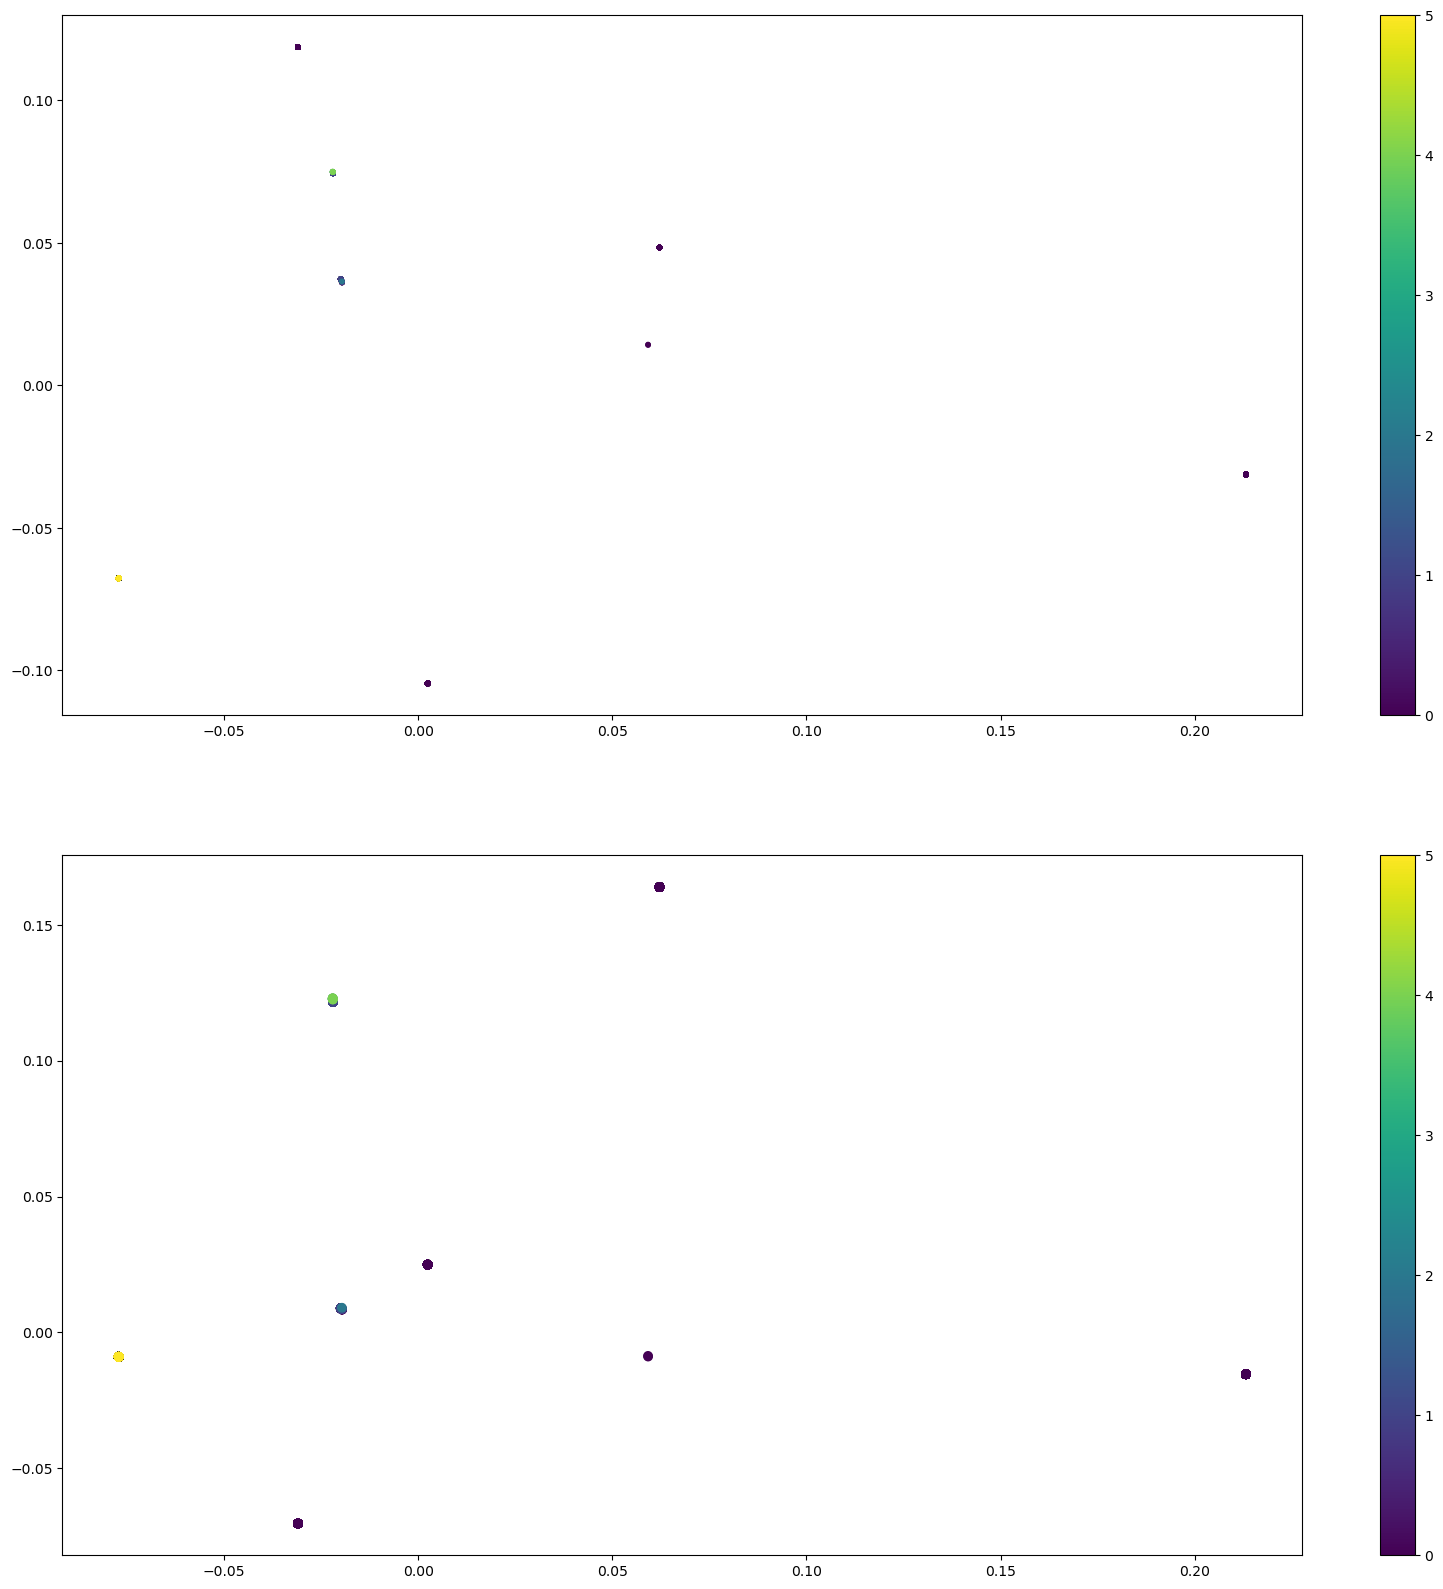

In [35]:
fig = plt.figure(figsize=(20,20))
plt.subplot(211)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,sizes=[10])
plt.colorbar()

plt.subplot(212)
plt.scatter(X_train[:,0],X_train[:,2],c=Y_train)
plt.colorbar()


plt.savefig('image2.png')

In [33]:
report_voted = perfomance_kpis(Y_voted, Y_test)
report_fitted = perfomance_kpis(Y_fitted, Y_test)
print('Luokitteluraportti, Majority voting')
print(report_voted)
print('Luokitteluraportti, etäisyyden minimointi')
print(report_fitted)

Luokitteluraportti, Majority voting
              precision    recall  f1-score   support

         0.0       0.52      0.36      0.42      1421
         1.0       0.19      0.61      0.29       147
         2.0       0.00      1.00      0.00         0
         3.0       0.00      1.00      0.00         0
         4.0       0.00      1.00      0.00         0
         5.0       0.00      0.00      0.00       620

    accuracy                           0.27      2188
   macro avg       0.12      0.66      0.12      2188
weighted avg       0.35      0.27      0.29      2188

Luokitteluraportti, etäisyyden minimointi
              precision    recall  f1-score   support

    -16151.0       1.00      0.00      0.00       1.0
    -16142.0       1.00      0.00      0.00       1.0
    -16118.0       1.00      0.00      0.00       1.0
    -16072.0       1.00      0.00      0.00       1.0
    -15904.0       1.00      0.00      0.00       2.0
    -15857.0       1.00      0.00      0.00       1.0


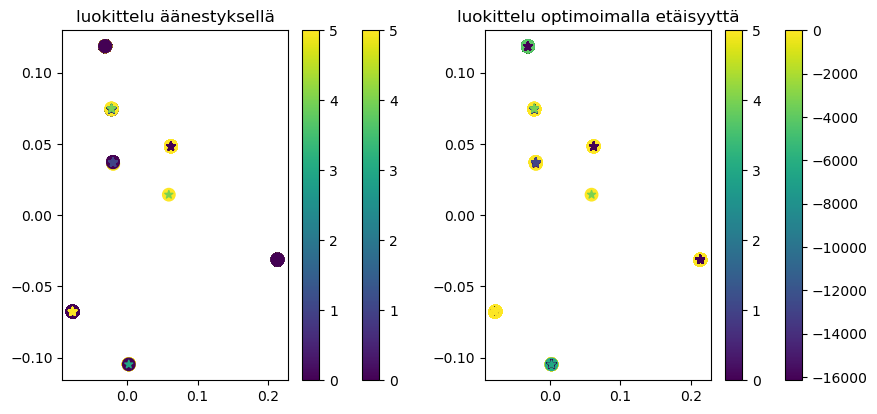

In [34]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter(X_test[:,0],X_test[:,1],marker='o',c=Y_voted,sizes=[80])
plt.colorbar()
plt.scatter(X_test[:,0],X_test[:,1],marker='*',c=Y_test)
plt.colorbar()
plt.title('luokittelu äänestyksellä')

plt.subplot(222)
plt.scatter(X_test[:,0],X_test[:,1],marker='o',c=Y_fitted,sizes=[80])
plt.colorbar()
plt.scatter(X_test[:,0],X_test[:,1],marker='*',c=Y_test)
plt.colorbar()
plt.title('luokittelu optimoimalla etäisyyttä')

plt.savefig('image.png')